In [18]:
#Script to obtain data 
from helpers import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import warnings
warnings.filterwarnings("ignore")
from spotipy import SpotifyClientCredentials, util

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
df = pd.read_csv("data/data_moods.csv")

In [5]:
col_features = df.columns[6:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

In [6]:
#Encodethe categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.4,random_state=100)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [7]:
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [8]:
#Configure the model
estimator = KerasClassifier(build_fn=base_model,epochs=600,batch_size=200,verbose=0)

In [9]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

Baseline: 80.30% (4.07%)


In [10]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

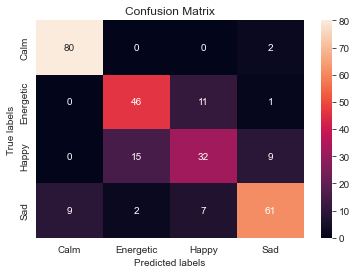

Accuracy Score 0.7963636363636364


In [11]:

cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [12]:
def predict_mood(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',estimator)])
    #Fit the Pipeline
    pip.fit(X2,encoded_y)

    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    return mood


In [13]:
id_lis = spotify_recommend()
print(id_lis)

['0O45fw2L5vsWpdsOdXwNAR', '2hgzdQdnfWwtdpZbhZlV72', '1z9kQ14XBSN0r2v6fx4IdG', '4hfIVhq0F0zFUcrbecsYmo', '13KCcVDJM9rrQlPgGtepK8', '63fyL7QZ1vhGZzZ9G56rcp', '7IohFKIwrb75c4XaqX7WWo', '2g1KggY9PKvsoEAOaiz4xx', '1RidHM9BC4M8DpfSQ6YLJh', '1kxyZ2SpflM1ogD0B5hgfX']


In [14]:
result = {}
for iterator in id_lis:
    result[iterator] = predict_mood(iterator)[0]
    song_features = get_songs_features(iterator)
    print("{0} is a {1} song".format(song_features[0][0],result[iterator].upper()))


SexyBack (feat. Timbaland) is a HAPPY song
Ain't Your Mama is a HAPPY song
Diamonds is a ENERGETIC song
Let's Get It Started - Spike Mix is a HAPPY song
No Excuses is a HAPPY song
Hangover - Hardwell Remix Radio Edit is a ENERGETIC song
This Is Love is a ENERGETIC song
Daisy is a HAPPY song
Up is a HAPPY song
Can't Believe It (feat. Pitbull) is a HAPPY song


In [15]:
lis = [i for i in result.keys() if result[i] == 'Happy']
print(lis)

['0O45fw2L5vsWpdsOdXwNAR', '2hgzdQdnfWwtdpZbhZlV72', '4hfIVhq0F0zFUcrbecsYmo', '13KCcVDJM9rrQlPgGtepK8', '2g1KggY9PKvsoEAOaiz4xx', '1RidHM9BC4M8DpfSQ6YLJh', '1kxyZ2SpflM1ogD0B5hgfX']


In [20]:
import configparser

config = configparser.ConfigParser()
config.read('application.properties')

redirect_uri = config.get("SpotifyCredentials", "redirect_uri")
username = config.get("SpotifyCredentials", "username")
scope_playlist = 'playlist-modify-public'
scope_user = 'user-library-modify'
scope_playing = 'user-read-currently-playing'

#Credentials to access the Spotify Music Data
manager = SpotifyClientCredentials(client_id,client_secret)
sp = spotipy.Spotify(client_credentials_manager=manager)

#Credentials to access the actual song played
token_actual = util.prompt_for_user_token(username,scope_playing,client_id,client_secret,redirect_uri)
sp_actual = spotipy.Spotify(auth=token_actual)

#Credentiasl to acces the library music
token_user= util.prompt_for_user_token(username,scope_user,client_id,client_secret,redirect_uri)
sp_user = spotipy.Spotify(auth=token_user)

#Credentiasl to acces the Playlists Music
token_playlist= util.prompt_for_user_token(username,scope_playlist,client_id,client_secret,redirect_uri)
sp_playlist = spotipy.Spotify(auth=token_playlist)

http://localhost:8080/callback 313k43wbq4zb2igxzhcqcrujnjsm


In [17]:
playlist = sp_playlist.user_playlist_create(username,"HappyPlaylist")
playlist_id = playlist["id"]
sp_playlist.user_playlist_add_tracks(username, playlist_id, lis)

{'snapshot_id': 'MixkNmExMzAxZmExYmUwNDMwMjVmMTRkYTEzZTgwNWZlMzYxM2JhMmE1'}